<a href="https://colab.research.google.com/github/assanalimarwa/Transformer_Fault_prognosis/blob/main/LoadCurrent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#test

import os
import scipy.io as io
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import math
import pickle


# Set random seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)



# Print TensorFlow version for reference
print(f"TensorFlow version: {tf.__version__}")

file_ind = ['2.5', '3', '3.5', '4', '4.5', '5',
            '5.5', '6', '7', '8', '8.4', '9',
            '9.5', '10', '11', '12', '13', '15']



Fs=3000
st=0.02 #stationary interval in terms of second
L=60

StartOfSignal=[80000, 45000, 52000, 70000, 70000, 42000, 30000, 34000,
               50000, 57000, 56000, 75000, 47000, 28000, 50000, 50000,
               50000, 48000]

#%% divide between train, validation, and test
data_train_list = []
data_valid_list = []
data_test_list = []
import numpy as np
k=-1
for file in file_ind:
    k = k + 1
#   there is a file for each subject in erp-data folder named by the following format: subject1.mat
    f = io.loadmat('load_current_'+file+'A.mat')
#   go through matlab maps to get the data
    a = float(file)*np.ones((len(f['Data1_AI_1']), 1))
    b = np.double(f['Data1_AI_1'])
    a = a[StartOfSignal[k]:]
    b = b[StartOfSignal[k]:]
    N=len(b)
    I=np.floor(N/L)-1  #total number of observations (N/L)
    Ntest=int(np.floor(I/4))   #we set 1/4 of I for test
    Nvalid = int(np.floor(3*I/16)) #validation is 1/4 of the 3/4*I (training) = 3/16
    Ntrain=int(I-Nvalid-Ntest)
    train_ind_max = Ntrain*L
    valid_ind_max = train_ind_max+Nvalid*L
    test_ind_max = valid_ind_max+Ntest*L

    data_temp_train = np.concatenate((a[0:train_ind_max], b[0:train_ind_max]), axis=1)
    data_temp_valid = np.concatenate((a[train_ind_max:valid_ind_max], b[train_ind_max:valid_ind_max]), axis=1)
    data_temp_test = np.concatenate((a[valid_ind_max:test_ind_max], b[valid_ind_max:test_ind_max]), axis=1)
    data_train_list.append(data_temp_train)
    data_valid_list.append(data_temp_valid)
    data_test_list.append(data_temp_test)


data_train = np.concatenate(data_train_list, axis=0) #convert the list to np arrays
data_valid = np.concatenate(data_valid_list, axis=0)
data_test = np.concatenate(data_test_list, axis=0)



#%% Normalize using mean and std of training


dmin=data_train.min(axis=0)
dmax=data_train.max(axis=0)
max_min = dmax - dmin
data_train  = (data_train-dmin)/max_min
data_valid  = (data_valid-dmin)/max_min
data_test  = (data_test-dmin)/max_min

#%% data generator

window = L
step = 1
delay = 0
batch_size = 64
print(L)

def generator(data, window, delay, min_index, max_index,
              shuffle=False, batch_size=batch_size, step=step):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + window

    while 1:
        if shuffle:
            sample_ind = np.random.randint(
                    min_index, max_index//window, size=batch_size)
            rows = sample_ind*window
        else:
            if i >= max_index:
                    i = min_index + window
            rows = np.arange(i, min(i + batch_size*window, max_index), window)
            i = rows[-1]+window
        samples = np.zeros((len(rows),
                            window // step,
                            (data.shape[-1]-1))) #second argument is the number of time stamps (1440/6)
                            # first argument is number of samples (indepedent)
                            #third arg is e.g. 12 (size of features)
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - window, rows[j], step)
            samples[j] = data[indices,1:] #indexing reducing dimenion but slicing doesn't
            #d_min = np.amin(data[indices,1:],axis=0)
            #samples[j] = (data[indices,1:]-d_min)/(np.amax(data[indices,1:],axis=0)-d_min)
            #d_min = np.amin(data[indices,1:],axis=0)
            targets[j] = data[rows[j]-1 + delay][0] #target is the first column
        yield samples, targets



#%%
train_gen = generator(data_train,
                      window=window,
                      delay=delay,
                      min_index=0,
                      max_index=None,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size) #see what None does
#%%
val_gen = generator(data_valid,
                    window=window,
                    delay=delay,
                    min_index=0,
                    max_index=None,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)

#%%
test_gen = generator(data_test,
                    window=window,
                    delay=delay,
                    min_index=0,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

#%%
val_steps = data_valid.shape[0]//(window*batch_size)
test_steps = data_test.shape[0]//(window*batch_size)


#import numpy as np
def to_str(var):
    return str(list(np.reshape(np.asarray(var), (1, np.size(var)))[0]))[1:-1]

units = [[128, 128, 128, 128, 128, 128, 128]]
# units = [[32,32,32

import keras
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, LSTM, GRU, Dense
import math
from keras.optimizers import RMSprop
from keras.optimizers import Adam, AdamW
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Dropout


import tensorflow as tf
from tensorflow.keras import layers, Model




# Example usage
for num_units in units:
    filenameFig = 'Load_BiLSTM_init_7'

    for num_unit in num_units:
      filenameFig = filenameFig + '_' + str(num_unit)
    filename = filenameFig
    filename_model = filename + '.h5'


    model = Sequential()

    if len(num_units) == 1:

        model.add(Bidirectional(LSTM(num_units[0]),
                         input_shape=(window//step,1)))

    else:
        model.add(Bidirectional(LSTM(num_units[0],
                     return_sequences=True),
                     input_shape=(window//step,1)))
        # model.add(Dropout(0.2))



        for i in range(1,len(num_units) - 1):
            model.add(Bidirectional(LSTM(num_units[i],
                                 return_sequences=True)))


        model.add(Bidirectional(LSTM(num_units[-1])))

    model.add(Dense(1))

    # model.compile(optimizer=RMSprop(lr=0.001), loss='mse', metrics=['mae','mape'])
    model.summary()

    model.compile(optimizer=AdamW(learning_rate=0.0001), loss='mse', metrics=['mae','mape'])
    history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=150,
                              validation_data=val_gen,
                              validation_steps=val_steps)
    #save model


    #save model

    model.save(filename + '.keras')

    import pickle
    with open(filename, 'wb') as handle:
        pickle.dump(history.history, handle)

    data_test_for_evaluate = data_valid[:,1:].reshape((len(data_valid)//window, window, 1))
    targets_test = data_valid[:,:1].reshape((len(data_valid)//window, window, 1))
    sample = np.zeros((1, window // step,
                                (data_valid.shape[-1]-1)))
    predicted_targets = np.zeros((len(data_test_for_evaluate),))
    true_targets = np.zeros((len(data_test_for_evaluate),))

    for i in range(0,len(data_test_for_evaluate)):
        true_targets[i] = targets_test[i,window-1]
    target_mean = true_targets.mean(axis=0)

    for i in range(0,len(data_test_for_evaluate)):
        sample[0] = data_test_for_evaluate[i,]
        predicted_targets[i]=model.predict(sample)

    MSE = sum(abs(predicted_targets-true_targets)**2)/len(true_targets)
    MAE = sum(abs(predicted_targets-true_targets))/len(true_targets)

    RRSE = 100 * np.sqrt(MSE * len(true_targets) / (sum(abs(true_targets-target_mean)**2)))
    RAE = 100 * MAE * len(true_targets) / sum(abs(true_targets-target_mean))

    print('MSE: ', MSE)
    print('MAE: ', MAE)
    print('RRSE: ', RRSE)
    print('RAE: ', RAE)
    print('target_mean: ', target_mean)
    print('len(true_targets): ', len(true_targets))
    print(sum(abs(true_targets-target_mean)**2))
    print(sum(abs(true_targets-target_mean))/len(true_targets))
    #plot
    fig=plt.figure()
    ax = fig.add_subplot(111)
    # if we would like to read from a saved "history"

    epoch_count = range(1, len(history.history['loss']) + 1)
    #plt.plot(epoch_count, np.array(d['loss']), 'b--', labe$\mathit{M}$=$\mathit{L}$='training MAE')
    #plt.plot(epoch_count, np.array(d['val_loss']), 'r-', labe$\mathit{M}$=$\mathit{L}$='validation MAE')
    plt.plot(epoch_count, np.array(history.history['loss']), 'b--')
    plt.plot(epoch_count, np.array(history.history['val_loss']), 'r-')
    y=history.history['val_loss']
    ymin = min(y)
    xpos = y.index(min(y))
    xmin = epoch_count[xpos]
    y=history.history['val_mae']
    yymin = min(y)

    print('MSE by formula: ', MSE, ' MSE by model: ', ymin)

    string1 = 'MSE = ' + '%.2E' % float(ymin)
    string2 = '\n' + 'RAE = ' + to_str(round(RAE,2)) + '%' + '\n' + 'RRSE = ' + to_str(round(RRSE,2)) + '%'
    string = string1 + string2
    ax.annotate(string, xy=(xmin, ymin),xycoords='data',
                 xytext=(-80, 85), textcoords='offset points',
                 bbox=dict(boxstyle="round4,pad=.5", fc="0.8"),
                 size=12,
                 arrowprops=dict(arrowstyle="->"))
    plt.title('$\mathit{N}$=' + str(len(num_units)) + ', $\mathit{M}$=$\mathit{L}$=' + str(num_units[0]))
    #xint = range(min(epoch_count), 15,2)
    xint = range(min(epoch_count)-1, math.ceil(max(epoch_count)),20)
    plt.xticks(xint)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend(loc="best")
    filename1 = filename + '_loss'
    fig.set_size_inches(5.46, 3.83)
    fig.savefig(filename1 + '.pdf', bbox_inches='tight')


    #1st element of score: MSE (keras)
    #2nd element of score: MSE
    #3nd element of score: MAE
    #4th element of score: RRSE
    #5th element of score: RAE
    score = []
    score.append(ymin)
    score.append(MSE)
    score.append(MAE)
    score.append(RRSE)
    score.append(RAE)
    filenameTXT = filename + '.txt'
    np.savetxt(filenameTXT, score)

    K.clear_session()
    del model


TensorFlow version: 2.17.0
60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 60, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 60, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 60, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 60, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 60, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 60, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,498,817 (9.53 MB)

 Trainable params: 2,498,817 (9.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


TypeError: Exception encountered when calling LSTM.call().

[1mExpected int32, but got None of type 'NoneType'.[0m

Arguments received by LSTM.call():
  • sequences=tf.Tensor(shape=(None, 60, 256), dtype=float32)
  • initial_state=None
  • mask=None
  • training=True

In [ ]:
#test

import os
import scipy.io as io
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import math
import pickle


# Set random seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)



# Print TensorFlow version for reference
print(f"TensorFlow version: {tf.__version__}")

file_ind = ['2.5', '3', '3.5', '4', '4.5', '5',
            '5.5', '6', '7', '8', '8.4', '9',
            '9.5', '10', '11', '12', '13', '15']



Fs=3000
st=0.02 #stationary interval in terms of second
L=60

StartOfSignal=[80000, 45000, 52000, 70000, 70000, 42000, 30000, 34000,
               50000, 57000, 56000, 75000, 47000, 28000, 50000, 50000,
               50000, 48000]

#%% divide between train, validation, and test
data_train_list = []
data_valid_list = []
data_test_list = []
import numpy as np
k=-1
for file in file_ind:
    k = k + 1
#   there is a file for each subject in erp-data folder named by the following format: subject1.mat
    f = io.loadmat('load_current_'+file+'A.mat')
#   go through matlab maps to get the data
    a = float(file)*np.ones((len(f['Data1_AI_1']), 1))
    b = np.double(f['Data1_AI_1'])
    a = a[StartOfSignal[k]:]
    b = b[StartOfSignal[k]:]
    N=len(b)
    I=np.floor(N/L)-1  #total number of observations (N/L)
    Ntest=int(np.floor(I/4))   #we set 1/4 of I for test
    Nvalid = int(np.floor(3*I/16)) #validation is 1/4 of the 3/4*I (training) = 3/16
    Ntrain=int(I-Nvalid-Ntest)
    train_ind_max = Ntrain*L
    valid_ind_max = train_ind_max+Nvalid*L
    test_ind_max = valid_ind_max+Ntest*L

    data_temp_train = np.concatenate((a[0:train_ind_max], b[0:train_ind_max]), axis=1)
    data_temp_valid = np.concatenate((a[train_ind_max:valid_ind_max], b[train_ind_max:valid_ind_max]), axis=1)
    data_temp_test = np.concatenate((a[valid_ind_max:test_ind_max], b[valid_ind_max:test_ind_max]), axis=1)
    data_train_list.append(data_temp_train)
    data_valid_list.append(data_temp_valid)
    data_test_list.append(data_temp_test)


data_train = np.concatenate(data_train_list, axis=0) #convert the list to np arrays
data_valid = np.concatenate(data_valid_list, axis=0)
data_test = np.concatenate(data_test_list, axis=0)



#%% Normalize using mean and std of training


dmin=data_train.min(axis=0)
dmax=data_train.max(axis=0)
max_min = dmax - dmin
data_train  = (data_train-dmin)/max_min
data_valid  = (data_valid-dmin)/max_min
data_test  = (data_test-dmin)/max_min

#%% data generator

window = L
step = 1
delay = 0
batch_size = 64
print(L)

def generator(data, window, delay, min_index, max_index,
              shuffle=False, batch_size=batch_size, step=step):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + window

    while 1:
        if shuffle:
            sample_ind = np.random.randint(
                    min_index, max_index//window, size=batch_size)
            rows = sample_ind*window
        else:
            if i >= max_index:
                    i = min_index + window
            rows = np.arange(i, min(i + batch_size*window, max_index), window)
            i = rows[-1]+window
        samples = np.zeros((len(rows),
                            window // step,
                            (data.shape[-1]-1))) #second argument is the number of time stamps (1440/6)
                            # first argument is number of samples (indepedent)
                            #third arg is e.g. 12 (size of features)
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - window, rows[j], step)
            samples[j] = data[indices,1:] #indexing reducing dimenion but slicing doesn't
            #d_min = np.amin(data[indices,1:],axis=0)
            #samples[j] = (data[indices,1:]-d_min)/(np.amax(data[indices,1:],axis=0)-d_min)
            #d_min = np.amin(data[indices,1:],axis=0)
            targets[j] = data[rows[j]-1 + delay][0] #target is the first column
        yield samples, targets



#%%
train_gen = generator(data_train,
                      window=window,
                      delay=delay,
                      min_index=0,
                      max_index=None,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size) #see what None does
#%%
val_gen = generator(data_valid,
                    window=window,
                    delay=delay,
                    min_index=0,
                    max_index=None,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)

#%%
test_gen = generator(data_test,
                    window=window,
                    delay=delay,
                    min_index=0,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

#%%
val_steps = data_valid.shape[0]//(window*batch_size)
test_steps = data_test.shape[0]//(window*batch_size)


#import numpy as np
def to_str(var):
    return str(list(np.reshape(np.asarray(var), (1, np.size(var)))[0]))[1:-1]

units = [[64, 64, 64, 64, 64]]
# units = [[32,32,32

import keras
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, LSTM, GRU, Dense
import math
from keras.optimizers import RMSprop
from keras.optimizers import Adam, AdamW
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Dropout


import tensorflow as tf
from tensorflow.keras import layers, Model




# Example usage
for num_units in units:
    filenameFig = 'Load_BiGRU_init'

    for num_unit in num_units:
      filenameFig = filenameFig + '_' + str(num_unit)
    filename = filenameFig
    filename_model = filename + '.h5'


    model = Sequential()

    if len(num_units) == 1:

        model.add(Bidirectional(GRU(num_units[0]),
                         input_shape=(window//step,1)))

    else:
        model.add(Bidirectional(GRU(num_units[0],
                     return_sequences=True),
                     input_shape=(window//step,1)))
        # model.add(Dropout(0.2))



        for i in range(1,len(num_units) - 1):
            model.add(Bidirectional(GRU(num_units[i],
                                 return_sequences=True)))


        model.add(Bidirectional(GRU(num_units[-1])))

    model.add(Dense(1))

    # model.compile(optimizer=RMSprop(lr=0.001), loss='mse', metrics=['mae','mape'])
    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae','mape'])
    history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=150,
                              validation_data=val_gen,
                              validation_steps=val_steps)
    #save model


    #save model

    model.save(filename + '.keras')

    import pickle
    with open(filename, 'wb') as handle:
        pickle.dump(history.history, handle)

    data_test_for_evaluate = data_valid[:,1:].reshape((len(data_valid)//window, window, 1))
    targets_test = data_valid[:,:1].reshape((len(data_valid)//window, window, 1))
    sample = np.zeros((1, window // step,
                                (data_valid.shape[-1]-1)))
    predicted_targets = np.zeros((len(data_test_for_evaluate),))
    true_targets = np.zeros((len(data_test_for_evaluate),))

    for i in range(0,len(data_test_for_evaluate)):
        true_targets[i] = targets_test[i,window-1]
    target_mean = true_targets.mean(axis=0)

    for i in range(0,len(data_test_for_evaluate)):
        sample[0] = data_test_for_evaluate[i,]
        predicted_targets[i]=model.predict(sample)

    MSE = sum(abs(predicted_targets-true_targets)**2)/len(true_targets)
    MAE = sum(abs(predicted_targets-true_targets))/len(true_targets)

    RRSE = 100 * np.sqrt(MSE * len(true_targets) / (sum(abs(true_targets-target_mean)**2)))
    RAE = 100 * MAE * len(true_targets) / sum(abs(true_targets-target_mean))

    print('MSE: ', MSE)
    print('MAE: ', MAE)
    print('RRSE: ', RRSE)
    print('RAE: ', RAE)
    print('target_mean: ', target_mean)
    print('len(true_targets): ', len(true_targets))
    print(sum(abs(true_targets-target_mean)**2))
    print(sum(abs(true_targets-target_mean))/len(true_targets))
    #plot
    fig=plt.figure()
    ax = fig.add_subplot(111)
    # if we would like to read from a saved "history"

    epoch_count = range(1, len(history.history['loss']) + 1)
    #plt.plot(epoch_count, np.array(d['loss']), 'b--', labe$\mathit{M}$=$\mathit{L}$='training MAE')
    #plt.plot(epoch_count, np.array(d['val_loss']), 'r-', labe$\mathit{M}$=$\mathit{L}$='validation MAE')
    plt.plot(epoch_count, np.array(history.history['loss']), 'b--')
    plt.plot(epoch_count, np.array(history.history['val_loss']), 'r-')
    y=history.history['val_loss']
    ymin = min(y)
    xpos = y.index(min(y))
    xmin = epoch_count[xpos]
    y=history.history['val_mae']
    yymin = min(y)

    print('MSE by formula: ', MSE, ' MSE by model: ', ymin)

    string1 = 'MSE = ' + '%.2E' % float(ymin)
    string2 = '\n' + 'RAE = ' + to_str(round(RAE,2)) + '%' + '\n' + 'RRSE = ' + to_str(round(RRSE,2)) + '%'
    string = string1 + string2
    ax.annotate(string, xy=(xmin, ymin),xycoords='data',
                 xytext=(-80, 85), textcoords='offset points',
                 bbox=dict(boxstyle="round4,pad=.5", fc="0.8"),
                 size=12,
                 arrowprops=dict(arrowstyle="->"))
    plt.title('$\mathit{N}$=' + str(len(num_units)) + ', $\mathit{M}$=$\mathit{L}$=' + str(num_units[0]))
    #xint = range(min(epoch_count), 15,2)
    xint = range(min(epoch_count)-1, math.ceil(max(epoch_count)),20)
    plt.xticks(xint)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend(loc="best")
    filename1 = filename + '_loss'
    fig.set_size_inches(5.46, 3.83)
    fig.savefig(filename1 + '.pdf', bbox_inches='tight')


    #1st element of score: MSE (keras)
    #2nd element of score: MSE
    #3nd element of score: MAE
    #4th element of score: RRSE
    #5th element of score: RAE
    score = []
    score.append(ymin)
    score.append(MSE)
    score.append(MAE)
    score.append(RRSE)
    score.append(RAE)
    filenameTXT = filename + '.txt'
    np.savetxt(filenameTXT, score)

    K.clear_session()
    del model


TensorFlow version: 2.17.0
60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 60, 128)             │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 60, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 60, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 60, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,841 (1.24 MB)

 Trainable params: 323,841 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.0957 - mae: 0.2671 - mape: 48399556.0000 - val_loss: 0.0533 - val_mae: 0.1766 - val_mape: 32193948.0000
Epoch 2/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0377 - mae: 0.1513 - mape: 19755968.0000 - val_loss: 0.0200 - val_mae: 0.1091 - val_mape: 10166368.0000
Epoch 3/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0165 - mae: 0.0993 - mape: 9615577.0000 - val_loss: 0.0144 - val_mae: 0.0900 - val_mape: 5043321.0000
Epoch 4/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0122 - mae: 0.0856 - mape: 6870659.0000 - val_loss: 0.0151 - val_mae: 0.0995 - val_mape: 19184280.0000
Epoch 5/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0097 - mae: 0.0761 - mape: 5797402.0000 - val_loss: 0.0091 - val_mae: 0.0789 - val_mape: 10062230.0000
Epoch 6/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0085 - mae: 0.0710 - mape: 5772620.5000 - val_loss: 0.0088 - val_mae: 0.0777 - val_mape: 11222

TensorFlow version: 2.17.1
60


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 60, 64)         │          8,704 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 60, 64)         │         24,832 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 60, 64)         │         24,832 │ bidirectional_1[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 60, 64)         │         24,832 │ bidirectional_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 60, 64)         │         24,832 │ bidirectional_3[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 60, 64)         │          4,208 │ bidirectional_4[0][0], │
│ (MultiHeadAttention)      │                        │                │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3840)           │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │          3,841 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 116,081 (453.44 KB)

 Trainable params: 116,081 (453.44 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 60, 64)         │          8,704 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 60, 64)         │         24,832 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 60, 64)         │         24,832 │ bidirectional_1[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 60, 64)         │         24,832 │ bidirectional_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 60, 64)         │         24,832 │ bidirectional_3[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 60, 64)         │          4,208 │ bidirectional_4[0][0], │
│ (MultiHeadAttention)      │                        │                │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3840)           │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │          3,841 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 116,081 (453.44 KB)

 Trainable params: 116,081 (453.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - loss: 0.0786 - mae: 0.2281 - mape: 37484100.0000 - val_loss: 0.0095 - val_mae: 0.0704 - val_mape: 11624358.0000
Epoch 2/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0057 - mae: 0.0568 - mape: 5118537.0000 - val_loss: 0.0042 - val_mae: 0.0465 - val_mape: 5824367.5000
Epoch 3/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0029 - mae: 0.0405 - mape: 3470517.5000 - val_loss: 0.0046 - val_mae: 0.0513 - val_mape: 3557259.0000
Epoch 4/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0025 - mae: 0.0371 - mape: 2927187.5000 - val_loss: 0.0045 - val_mae: 0.0475 - val_mape: 3447818.5000
Epoch 5/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0023 - mae: 0.0357 - mape: 2713904.5000 - val_loss: 0.0031 - val_mae: 0.0386 - val_mape: 2237137.5000
Epoch 6/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.0020 - mae: 0.0326 - mape: 2438071.0000 - val_loss: 0.0033 - val_mae: 0.0413 - val_mape: 3855841.7

<ipython-input-1-a4edb2e2a914>:247: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_targets[i] = targets_test[i,window-1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<ipython-input-1-a4edb2e2a914>:252: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_targets[i]=model.predict(sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

MSE:  0.0012174246033652616
MAE:  0.018867726370512095
RRSE:  11.52787979585021
RAE:  7.035485604007141
target_mean:  0.35373224884590015
len(true_targets):  4549
416.7341898791076
0.2681794467714605
MSE by formula:  0.0012174246033652616  MSE by model:  0.0008405024418607354


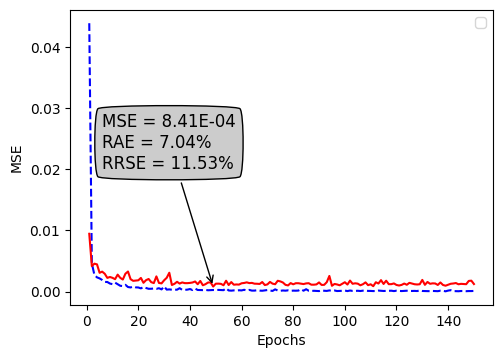

In [ ]:
import os
import scipy.io as io
import numpy as np
import tensorflow as tf
import random
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, Dense, Dropout
from keras.optimizers import RMSprop, AdamW, SGD
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.keras import layers, Model, models
from typing import Tuple
import math



# Set random seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)



# Print TensorFlow version for reference
print(f"TensorFlow version: {tf.__version__}")

file_ind = ['2.5', '3', '3.5', '4', '4.5', '5',
            '5.5', '6', '7', '8', '8.4', '9',
            '9.5', '10', '11', '12', '13', '15']



Fs=3000
st=0.02 #stationary interval in terms of second
L=60

StartOfSignal=[80000, 45000, 52000, 70000, 70000, 42000, 30000, 34000,
               50000, 57000, 56000, 75000, 47000, 28000, 50000, 50000,
               50000, 48000]

#%% divide between train, validation, and test
data_train_list = []
data_valid_list = []
data_test_list = []
import numpy as np
k=-1
for file in file_ind:
    k = k + 1
#   there is a file for each subject in erp-data folder named by the following format: subject1.mat
    f = io.loadmat('load_current_'+file+'A.mat')
#   go through matlab maps to get the data
    a = float(file)*np.ones((len(f['Data1_AI_1']), 1))
    b = np.double(f['Data1_AI_1'])
    a = a[StartOfSignal[k]:]
    b = b[StartOfSignal[k]:]
    N=len(b)
    I=np.floor(N/L)-1  #total number of observations (N/L)
    Ntest=int(np.floor(I/4))   #we set 1/4 of I for test
    Nvalid = int(np.floor(3*I/16)) #validation is 1/4 of the 3/4*I (training) = 3/16
    Ntrain=int(I-Nvalid-Ntest)
    train_ind_max = Ntrain*L
    valid_ind_max = train_ind_max+Nvalid*L
    test_ind_max = valid_ind_max+Ntest*L

    data_temp_train = np.concatenate((a[0:train_ind_max], b[0:train_ind_max]), axis=1)
    data_temp_valid = np.concatenate((a[train_ind_max:valid_ind_max], b[train_ind_max:valid_ind_max]), axis=1)
    data_temp_test = np.concatenate((a[valid_ind_max:test_ind_max], b[valid_ind_max:test_ind_max]), axis=1)
    data_train_list.append(data_temp_train)
    data_valid_list.append(data_temp_valid)
    data_test_list.append(data_temp_test)


data_train = np.concatenate(data_train_list, axis=0) #convert the list to np arrays
data_valid = np.concatenate(data_valid_list, axis=0)
data_test = np.concatenate(data_test_list, axis=0)



#%% Normalize using mean and std of training


dmin=data_train.min(axis=0)
dmax=data_train.max(axis=0)
max_min = dmax - dmin
data_train  = (data_train-dmin)/max_min
data_valid  = (data_valid-dmin)/max_min
data_test  = (data_test-dmin)/max_min

#%% data generator

window = L
step = 1
delay = 0
batch_size = 64
print(L)

def generator(data, window, delay, min_index, max_index,
              shuffle=False, batch_size=batch_size, step=step):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + window

    while 1:
        if shuffle:
            sample_ind = np.random.randint(
                    min_index, max_index//window, size=batch_size)
            rows = sample_ind*window
        else:
            if i >= max_index:
                    i = min_index + window
            rows = np.arange(i, min(i + batch_size*window, max_index), window)
            i = rows[-1]+window
        samples = np.zeros((len(rows),
                            window // step,
                            (data.shape[-1]-1))) #second argument is the number of time stamps (1440/6)
                            # first argument is number of samples (indepedent)
                            #third arg is e.g. 12 (size of features)
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - window, rows[j], step)
            samples[j] = data[indices,1:] #indexing reducing dimenion but slicing doesn't
            #d_min = np.amin(data[indices,1:],axis=0)
            #samples[j] = (data[indices,1:]-d_min)/(np.amax(data[indices,1:],axis=0)-d_min)
            #d_min = np.amin(data[indices,1:],axis=0)
            targets[j] = data[rows[j]-1 + delay][0] #target is the first column
        yield samples, targets



#%%
train_gen = generator(data_train,
                      window=window,
                      delay=delay,
                      min_index=0,
                      max_index=None,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size) #see what None does
#%%
val_gen = generator(data_valid,
                    window=window,
                    delay=delay,
                    min_index=0,
                    max_index=None,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)

#%%
test_gen = generator(data_test,
                    window=window,
                    delay=delay,
                    min_index=0,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

#%%
val_steps = data_valid.shape[0]//(window*batch_size)
test_steps = data_test.shape[0]//(window*batch_size)


#import numpy as np
def to_str(var):
    return str(list(np.reshape(np.asarray(var), (1, np.size(var)))[0]))[1:-1]






def mhsa_bilstm(input_shape: Tuple[int, ...], bilstm_units: int, num_heads: int, head_dim: int, num_layers: int) -> models.Model:
    """
    Constructs a model with stacked BiLSTM layers followed by a Multi-Head Self-Attention (MHSA) layer.

    Args:
        input_shape (Tuple[int, ...]): Shape of the input data (e.g., (60, 1)).
        bigru_units (int): Number of units in each BiLSTM layer. Default is 32.
        num_heads (int): Number of attention heads for the MHSA layer. Default is 4.
        num_layers (int): Number of stacked BiGRU layers. Default is 5.

    Returns:
        models.Model: A compiled Keras model.
    """
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Stack BiGRU layers dynamically based on num_layers
    x = inputs
    for _ in range(num_layers):
        x = layers.Bidirectional(layers.LSTM(bilstm_units, return_sequences=True))(x)

    # Multi-Head Self-Attention layer
    mhsa = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_dim)(x, x)

    # Flatten the MHSA output
    flatten = layers.Flatten()(mhsa)

    # Output layer (single neuron for regression)
    outputs = layers.Dense(1)(flatten)

    # Create and return the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
input_shape = (60, 1)
model = mhsa_bilstm(input_shape, 32, 1, 16, 5)
model.summary()


filenameFig = ''

filenameFig = ''
filenameFig = filenameFig + '_'
filename = filenameFig
filename_model = filename + '.h5'


model.summary()

model.compile(optimizer=AdamW(learning_rate=0.001), loss='mse', metrics=['mae','mape'])
history = model.fit(train_gen,
                          steps_per_epoch=500,
                          epochs=150,
                          validation_data=val_gen,
                          validation_steps=val_steps)

model.save(filename + '.h5')


import pickle
with open(filename, 'wb') as handle:
    pickle.dump(history.history, handle)

data_test_for_evaluate = data_valid[:,1:].reshape((len(data_valid)//window, window, 1))
targets_test = data_valid[:,:1].reshape((len(data_valid)//window, window, 1))
sample = np.zeros((1, window // step,
                            (data_valid.shape[-1]-1)))
predicted_targets = np.zeros((len(data_test_for_evaluate),))
true_targets = np.zeros((len(data_test_for_evaluate),))

for i in range(0,len(data_test_for_evaluate)):
    true_targets[i] = targets_test[i,window-1]
target_mean = true_targets.mean(axis=0)

for i in range(0,len(data_test_for_evaluate)):
    sample[0] = data_test_for_evaluate[i,]
    predicted_targets[i]=model.predict(sample)

MSE = sum(abs(predicted_targets-true_targets)**2)/len(true_targets)
MAE = sum(abs(predicted_targets-true_targets))/len(true_targets)

RRSE = 100 * np.sqrt(MSE * len(true_targets) / (sum(abs(true_targets-target_mean)**2)))
RAE = 100 * MAE * len(true_targets) / sum(abs(true_targets-target_mean))

print('MSE: ', MSE)
print('MAE: ', MAE)
print('RRSE: ', RRSE)
print('RAE: ', RAE)
print('target_mean: ', target_mean)
print('len(true_targets): ', len(true_targets))
print(sum(abs(true_targets-target_mean)**2))
print(sum(abs(true_targets-target_mean))/len(true_targets))
#plot
fig=plt.figure()
ax = fig.add_subplot(111)
# if we would like to read from a saved "history"

epoch_count = range(1, len(history.history['loss']) + 1)
#plt.plot(epoch_count, np.array(d['loss']), 'b--', labe$\mathit{M}$=$\mathit{L}$='training MAE')
#plt.plot(epoch_count, np.array(d['val_loss']), 'r-', labe$\mathit{M}$=$\mathit{L}$='validation MAE')
plt.plot(epoch_count, np.array(history.history['loss']), 'b--')
plt.plot(epoch_count, np.array(history.history['val_loss']), 'r-')
y=history.history['val_loss']
ymin = min(y)
xpos = y.index(min(y))
xmin = epoch_count[xpos]
y=history.history['val_mae']
yymin = min(y)

print('MSE by formula: ', MSE, ' MSE by model: ', ymin)

string1 = 'MSE = ' + '%.2E' % float(ymin)
string2 = '\n' + 'RAE = ' + to_str(round(RAE,2)) + '%' + '\n' + 'RRSE = ' + to_str(round(RRSE,2)) + '%'
string = string1 + string2
ax.annotate(string, xy=(xmin, ymin),xycoords='data',
              xytext=(-80, 85), textcoords='offset points',
              bbox=dict(boxstyle="round4,pad=.5", fc="0.8"),
              size=12,
              arrowprops=dict(arrowstyle="->"))
plt.title('')
#xint = range(min(epoch_count), 15,2)
xint = range(min(epoch_count)-1, math.ceil(max(epoch_count)),20)
plt.xticks(xint)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc="best")
filename1 = filename + '_loss'
fig.set_size_inches(5.46, 3.83)
fig.savefig(filename1 + '.pdf', bbox_inches='tight')


#1st element of score: MSE (keras)
#2nd element of score: MSE
#3nd element of score: MAE
#4th element of score: RRSE
#5th element of score: RAE
score = []
score.append(ymin)
score.append(MSE)
score.append(MAE)
score.append(RRSE)
score.append(RAE)
filenameTXT = filename + '.txt'
np.savetxt(filenameTXT, score)

K.clear_session()
del model




In [ ]:
import tensorflow as tf
import numpy as np

# Load the model
try:
    modelt = tf.keras.models.load_model('/content/Load_attention_biLSTM_8x16_flat_64_64_64_64_64.h5', compile=False)
    print("Model loaded successfully with Keras (compile=False)")
except Exception as e:
    print(f"Error loading model with Keras (compile=False): {e}")
    raise  # Re-raise the exception to stop execution if model loading fails

Error loading model with Keras (compile=False): [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/Load_attention_biLSTM_8x16_flat_64_64_64_64_64.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/Load_attention_biLSTM_8x16_flat_64_64_64_64_64.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
data_test_for_evaluate = data_test[:,1:].reshape((len(data_test)//window, window, 1))
targets_test = data_test[:,:1].reshape((len(data_test)//window, window, 1))
sample = np.zeros((1, window // step,
                            (data_test.shape[-1]-1)))
predicted_targets = np.zeros((len(data_test_for_evaluate),))
true_targets = np.zeros((len(data_test_for_evaluate),))

for i in range(0,len(data_test_for_evaluate)):
    true_targets[i] = targets_test[i,window-1]
target_mean = true_targets.mean(axis=0)

for i in range(0,len(data_test_for_evaluate)):
    sample[0] = data_test_for_evaluate[i,]
    predicted_targets[i]=modelt.predict(sample)

MSE = sum(abs(predicted_targets-true_targets)**2)/len(true_targets)
MAE = sum(abs(predicted_targets-true_targets))/len(true_targets)

RRSE = 100 * np.sqrt(MSE * len(true_targets) / (sum(abs(true_targets-target_mean)**2)))
RAE = 100 * MAE * len(true_targets) / sum(abs(true_targets-target_mean))

print('MSE: ', MSE)
print('MAE: ', MAE)
print('RRSE: ', RRSE)
print('RAE: ', RAE)
print('target_mean: ', target_mean)
print('len(true_targets): ', len(true_targets))
print(sum(abs(true_targets-target_mean)**2))
print(sum(abs(true_targets-target_mean))/len(true_targets))

NameError: name 'data_test' is not defined

In [ ]:
import tensorflow as tf
import numpy as np

# Load the model
try:
    modely = tf.keras.models.load_model('/content/Load_attention_biLSTM_1x16_flat_32_32_32_32_32.h5', compile=False)
    print("Model loaded successfully with Keras (compile=False)")
except Exception as e:
    print(f"Error loading model with Keras (compile=False): {e}")
    raise  # Re-raise the exception to stop execution if model loading fails

Model loaded successfully with Keras (compile=False)


In [ ]:
data_test_for_evaluate = data_test[:,1:].reshape((len(data_test)//window, window, 1))
targets_test = data_test[:,:1].reshape((len(data_test)//window, window, 1))
sample = np.zeros((1, window // step,
                            (data_test.shape[-1]-1)))
predicted_targets = np.zeros((len(data_test_for_evaluate),))
true_targets = np.zeros((len(data_test_for_evaluate),))

for i in range(0,len(data_test_for_evaluate)):
    true_targets[i] = targets_test[i,window-1]
target_mean = true_targets.mean(axis=0)

for i in range(0,len(data_test_for_evaluate)):
    sample[0] = data_test_for_evaluate[i,]
    predicted_targets[i]=modely.predict(sample)

MSE = sum(abs(predicted_targets-true_targets)**2)/len(true_targets)
MAE = sum(abs(predicted_targets-true_targets))/len(true_targets)

RRSE = 100 * np.sqrt(MSE * len(true_targets) / (sum(abs(true_targets-target_mean)**2)))
RAE = 100 * MAE * len(true_targets) / sum(abs(true_targets-target_mean))

print('MSE: ', MSE)
print('MAE: ', MAE)
print('RRSE: ', RRSE)
print('RAE: ', RAE)
print('target_mean: ', target_mean)
print('len(true_targets): ', len(true_targets))
print(sum(abs(true_targets-target_mean)**2))
print(sum(abs(true_targets-target_mean))/len(true_targets))

<ipython-input-4-2a7897a8922f>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_targets[i] = targets_test[i,window-1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<ipython-input-4-2a7897a8922f>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_targets[i]=modely.predict(sample)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, LSTM, GRU, Dense
import math
from keras.optimizers import RMSprop
from keras.optimizers import Adam, AdamW
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Dropout


import tensorflow as tf
from tensorflow.keras import layers, Model


import keras
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, LSTM, GRU, Dense
import math
from keras.optimizers import RMSprop
from keras.optimizers import Adam, AdamW
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Dropout


import tensorflow as tf
from tensorflow.keras import layers, Model

from tensorflow.keras import layers, Model


def create_bilstm_mhsa_regression_model(input_shape, lstm_units=32, num_heads=1):
    inputs = layers.Input(shape=(60,1))

    # BiLSTM layer
    bilstm = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(inputs)
    bilstm = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(bilstm)
    bilstm = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(bilstm)
    bilstm = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(bilstm)
    bilstm = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(bilstm)
    # bilstm = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(bilstm)
    # bilstm = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(bilstm)


    # Multi-Head Self-Attention layer
    mhsa = layers.MultiHeadAttention(num_heads=num_heads, key_dim=16)(bilstm, bilstm, bilstm)

    # gmp = layers.GlobalMaxPooling1D()(mhsa)

    flatten = layers.Flatten()(mhsa)

    # gap = layers.GlobalAveragePooling1D()(mhsa)
    # combined = layers.concatenate([gap, gmp])
    # Global Average Pooling
    # gap = layers.GlobalMaxPooling1D()(mhsa)

    # Output layer (single neuron for regression)
    outputs = layers.Dense(1)(flatten)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
input_shape = (60, 1)
model = create_bilstm_mhsa_regression_model(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 60, 64)         │          8,704 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 60, 64)         │         24,832 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 60, 64)         │         24,832 │ bidirectional_1[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 60, 64)         │         24,832 │ bidirectional_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 60, 64)         │         24,832 │ bidirectional_3[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 60, 64)         │          4,208 │ bidirectional_4[0][0], │
│ (MultiHeadAttention)      │                        │                │ bidirectional_4[0][0], │
│                           │                        │                │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3840)           │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │          3,841 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 116,081 (453.44 KB)

 Trainable params: 116,081 (453.44 KB)

 Non-trainable params: 0 (0.00 B)